In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.modelUtils.gnn as gnn

In [2]:
graphs = gnn.Dataset('.')

In [3]:
ngraphs = len(graphs)
ngraphs

45168

In [7]:
loss_weights = np.array([ak.count(node_labels),ak.count(edge_labels)])
loss_weights = np.max(loss_weights)/loss_weights 

In [8]:
graphs[0]

Data(x=[7, 5], edge_index=[2, 49], y=[7], pos_edge_index=[2, 6], edge_x=[49, 1], edge_y=[49])

In [9]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

def train_test_split(dataset,test_split):
    size = len(dataset)
    train_size = int(size*(1-test_split))
    test_size = size - train_size
    return random_split(dataset,[train_size,test_size])

training,testing = train_test_split(graphs, 0.25)
training,validation = train_test_split(training,0.2)

trainloader = DataLoader(training,batch_size=50,shuffle=True,num_workers=4)
testloader = DataLoader(testing,batch_size=50,num_workers=4)
validloader = DataLoader(validation,batch_size=50,num_workers=4)

In [27]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torch_geometric.nn import Linear


class GCN(pl.LightningModule):
    def __init__(self, node_features, edge_features, nclasses):
        super().__init__()

        nn1 = torch.nn.Sequential(
            Linear(2*node_features+edge_features, 64),
            torch.nn.ReLU(),
            Linear(-1, 96),
            torch.nn.ReLU()
        )

        self.conv1 = gnn.EdgeConv(nn1, return_with_edges=True)

        node_classifier = torch.nn.Sequential(
            Linear(3*96, 128),
            torch.nn.ELU(),
            Linear(-1, nclasses)
        )

        edge_classifier = torch.nn.Sequential(
            Linear(3*96, 128),
            torch.nn.ELU(),
            Linear(-1, nclasses)
        )

        self.node_conv = gnn.EdgeConv(node_classifier)
        self.edge_conv = gnn.EdgeConv(edge_classifier, return_only_edges=True)

        self.node_class_weights = torch.Tensor(node_class_weights)
        self.edge_class_weights = torch.Tensor(edge_class_weights)

    def forward(self, data):
        x, edge_index, edge_x = data.x, data.edge_index, data.edge_x
        x_tilde, edge_x_tilde = self.conv1(x, edge_index, edge_x)
        x = self.node_conv(x_tilde, edge_index, edge_x_tilde)
        edge_x = self.edge_conv(x_tilde, edge_index, edge_x_tilde)

        return F.log_softmax(x, dim=1), F.log_softmax(edge_x, dim=1)

    def shared_step(self, batch, batch_idx, tag=None):
        node_o, edge_o = self(batch)

        node_loss = F.nll_loss(node_o, batch.y, self.node_class_weights)
        node_acc = accuracy(node_o.argmax(dim=1), batch.y)

        edge_loss = F.nll_loss(
            edge_o, batch.edge_y.long(), self.edge_class_weights)
        edge_acc = accuracy(edge_o.argmax(dim=1), batch.edge_y.long())

        loss = node_loss + edge_loss

        metrics = dict(loss=loss, node_loss=node_loss,
                       node_acc=node_acc, edge_loss=edge_loss, edge_acc=edge_acc)
        if tag is not None:
            metrics = {f'{tag}_{key}': value for key, value in metrics.items()}

        self.log_dict(metrics)
        return metrics

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, tag='val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, tag='test')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [28]:
model = GCN(5,1,2)

In [29]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(max_epochs=5,callbacks=[EarlyStopping(monitor='val_loss')])
trainer.fit(model,trainloader,validloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/uscms/home/ekoenig/nobackup/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/model_summary.py:431: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name      | Type     | Params
---------------------------------------
0 | conv1     | EdgeConv | 864   
1 | node_conv | EdgeConv | 37.0 K
2 | edge_conv | EdgeConv | 37.0 K
---------------------------------------
74.9 K    Trainable params
0         Non-trainable params
74.9 K    Total params
0.299     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [30]:
trainer.test(model,validloader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_edge_acc': 0.606505274772644,
 'test_edge_loss': 0.5574642419815063,
 'test_loss': 0.8665906190872192,
 'test_node_acc': 0.8785029053688049,
 'test_node_loss': 0.309126615524292}
--------------------------------------------------------------------------------


[{'test_loss': 0.8665906190872192,
  'test_node_loss': 0.309126615524292,
  'test_node_acc': 0.8785029053688049,
  'test_edge_loss': 0.5574642419815063,
  'test_edge_acc': 0.606505274772644}]

In [31]:
trainer.test(model,testloader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_edge_acc': 0.6062091588973999,
 'test_edge_loss': 0.5557989478111267,
 'test_loss': 0.8671642541885376,
 'test_node_acc': 0.8798198103904724,
 'test_node_loss': 0.3113655149936676}
--------------------------------------------------------------------------------


[{'test_loss': 0.8671642541885376,
  'test_node_loss': 0.3113655149936676,
  'test_node_acc': 0.8798198103904724,
  'test_edge_loss': 0.5557989478111267,
  'test_edge_acc': 0.6062091588973999}]

In [32]:
import sklearn.metrics as metrics

node_y_true,edge_y_true,node_y_pred,edge_y_pred = [],[],[],[]
for test in testloader: 
    nypred,eypred = model(test)

    node_y_true = np.concatenate([node_y_true,test.y])
    edge_y_true = np.concatenate([edge_y_true,test.edge_y.long()])

    node_y_pred = np.concatenate([node_y_pred,nypred[:,1].detach()])
    edge_y_pred = np.concatenate([edge_y_pred,eypred[:,1].detach()])

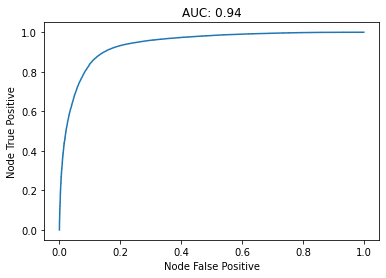

In [33]:
fpr,tpr,thresholds = metrics.roc_curve(node_y_true,node_y_pred)
auc = metrics.auc(fpr,tpr)

graph_simple(fpr,tpr,xlabel="Node False Positive",ylabel="Node True Positive",title=f"AUC: {auc:.2}",marker=None);

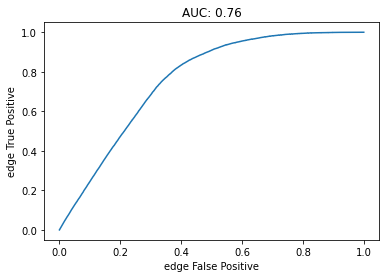

In [34]:
fpr,tpr,thresholds = metrics.roc_curve(edge_y_true,edge_y_pred)
auc = metrics.auc(fpr,tpr)

graph_simple(fpr,tpr,xlabel="edge False Positive",ylabel="edge True Positive",title=f"AUC: {auc:.2}",marker=None);